In [1]:
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import datetime
import yfinance as yf
import backtrader.feeds as btfeed
import backtrader as bt
#import backtrader.avanyzers as btanalyzers
%matplotlib inline
import datetime
from datetime import timedelta
from datetime import date

import backtrader.analyzers as btanalyzers

In [9]:
class SuperTrendBand(bt.Indicator):
    """
    Helper inidcator for Supertrend indicator
    """
    params = (('period',100),('multiplier',3))
    lines = ('basic_ub','basic_lb','final_ub','final_lb')
    plotinfo = dict(subplot=False)

    def __init__(self):
        self.atr = bt.indicators.AverageTrueRange(period=self.p.period)
        self.l.basic_ub = ((self.data.high + self.data.low) / 2) + (self.atr * self.p.multiplier)
        self.l.basic_lb = ((self.data.high + self.data.low) / 2) - (self.atr * self.p.multiplier)

    def next(self):
        if len(self)-1 == self.p.period:
            self.l.final_ub[0] = self.l.basic_ub[0]
            self.l.final_lb[0] = self.l.basic_lb[0]
        else:
            #=IF(OR(basic_ub<final_ub*,close*>final_ub*),basic_ub,final_ub*)
            if self.l.basic_ub[0] < self.l.final_ub[-1] or self.data.close[-1] > self.l.final_ub[-1]:
                self.l.final_ub[0] = self.l.basic_ub[0]
            else:
                self.l.final_ub[0] = self.l.final_ub[-1]

            #=IF(OR(baisc_lb > final_lb *, close * < final_lb *), basic_lb *, final_lb *)
            if self.l.basic_lb[0] > self.l.final_lb[-1] or self.data.close[-1] < self.l.final_lb[-1]:
                self.l.final_lb[0] = self.l.basic_lb[0]
            else:
                self.l.final_lb[0] = self.l.final_lb[-1]

class ATR_Compound_Indicator(bt.Indicator):
    params = (('period', 100), ('multiplier', 3))
    lines = ('ATR_comp_ind','ATRHigh', 'ATRLow',)
    plotinfo = dict(subplot=False)

    def __init__(self):
        self.stb = SuperTrendBand(period = self.p.period, multiplier = self.p.multiplier)

    def next(self):
        if len(self) - 1 == self.p.period:
            self.l.ATR_comp_ind[0] = self.stb.final_ub[0]
            return
        
        if self.l.ATR_comp_ind[-1] == self.stb.final_ub[-1]:
            if self.data.close[0] <= self.stb.final_ub[0]:
                self.l.ATR_comp_ind[0] = self.stb.final_ub[0]
            else:
                self.l.ATR_comp_ind[0] = self.stb.final_lb[0]

        if self.l.ATR_comp_ind[-1] == self.stb.final_lb[-1]:
            if self.data.close[0] >= self.stb.final_lb[0]:
                self.l.ATR_comp_ind[0] = self.stb.final_lb[0]
            else:
                self.l.ATR_comp_ind[0] = self.stb.final_ub[0]
        self.ATRHigh[0] = self.stb.final_ub[0]
        self.ATRLow[0] = self.stb.final_lb[0]

class ATR_High(bt.Indicator):
    params = (('period', 100), ('multiplier', 3))
    lines = ('ATRHigh', 'ATRHigh2',)
    plotinfo = dict(subplot=False)
    def __init__(self):
        self.stb = SuperTrendBand(period = self.p.period, multiplier = self.p.multiplier) 
        self.stb2 = SuperTrendBand(period = self.p.period, multiplier = 2*self.p.multiplier)
    def next(self):
        self.ATRHigh[0] = self.stb.final_ub[0]
        self.ATRHigh2[0] = self.stb2.final_ub[0]
        
class ATR_Low(bt.Indicator):
    params = (('period', 100), ('multiplier', 3))
    lines = ('ATRLow', 'ATRLow2',)
    plotinfo = dict(subplot=False)
    def __init__(self):
        self.stb = SuperTrendBand(period = self.p.period, multiplier = self.p.multiplier)
        self.stb2 = SuperTrendBand(period = self.p.period, multiplier = 2*self.p.multiplier)
    def next(self):
        self.ATRLow[0] = self.stb.final_lb[0]
        self.ATRLow2[0] = self.stb2.final_lb[0] 

class MyATRRevert(bt.Strategy):
    def __init__(self):   
        
        self.lines.ATRHigh = ATR_High(self.data, plot=False)
        self.lines.ATRLow = ATR_Low(self.data, plot=False)
        
    def next(self):
        if self.position.size == 0:
            if self.data[0] >= self.lines.ATRHigh[0]:
                self.sell()
            if self.data[0] <= self.lines.ATRLow[0]:
                self.buy()
                
        if self.position.size > 0:
            if self.data[0] <= self.lines.ATRLow[0]:
                self.close()
            if self.data[0] >= self.ATRHigh.ATRHigh2[0]:
                self.close()
                
        if self.position.size < 0:
            if self.data[0] <= self.ATRHigh.ATRHigh2[0]:
                self.close()
            if self.data[0] >= self.lines.ATRHigh[0]:
                self.close()

class MyATRTrend(bt.Strategy):  
    def __init__(self):   
        self.lines.ATR_comp_ind = ATR_Compound_Indicator(self.data, plot=False)
        
        
    def next(self):
        if self.position.size <= 0:
            if (self.data[0]>(self.lines.ATR_comp_ind)):
                self.buy()
            else: pass
        if self.position.size >= 0:
            if (self.data[0]<(self.lines.ATR_comp_ind)):
                self.sell() 
            else: pass


            
def run_Revert(start_val, dataset):
    %matplotlib inline
    cerebro = bt.Cerebro()
    cerebro.adddata(dataset)
    cerebro.addstrategy(MyATRRevert)
    cerebro.broker.setcash(start_val)
    cerebro.addsizer(bt.sizers.PercentSizer, percents=95)
    cerebro.addobserver(bt.observers.Value, plot = True)
    cerebro.addanalyzer(btanalyzers.SharpeRatio, _name='mysharpe')
    cerebro.addanalyzer(btanalyzers.DrawDown, _name='dd')
    result = cerebro.run(stdstats=True, timeframe=bt.TimeFrame.Minutes, compression=60)
    
    cerebro.plot()
    return(('Final Value:',cerebro.broker.getvalue()), ('Sharpe Ratio:', result[0].analyzers.mysharpe.get_analysis()),('Draw Down:', result[0].analyzers.dd.get_analysis()))
      
def run_Trend(start_val, dataset):
    %matplotlib inline
    cerebro = bt.Cerebro()
    cerebro.adddata(dataset)
    cerebro.addstrategy(MyATRTrend)
    cerebro.broker.setcash(start_val)
    cerebro.addsizer(bt.sizers.PercentSizer, percents=95)
    cerebro.addobserver(bt.observers.Value)
    result = cerebro.run(stdstats=True, timeframe=bt.TimeFrame.Minutes, compression=60)
    
    cerebro.plot()
    return(cerebro.broker.getvalue()-start_val)

In [3]:
day =  yf.download("EURUSD=X",start="2021-1-1", end="2021-12-30",interval = "1h") 
day = bt.feeds.PandasData(dataname=day, timeframe=bt.TimeFrame.Minutes, compression=60)

[*********************100%***********************]  1 of 1 completed


<IPython.core.display.Javascript object>


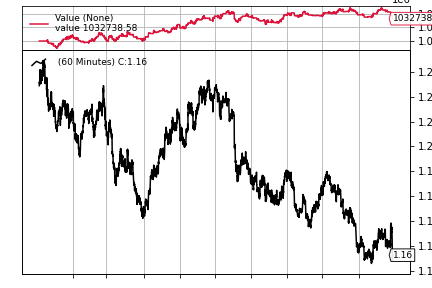

(('Final Value:', 1032738.5804294843),
 ('Sharpe Ratio:', OrderedDict([('sharperatio', None)])),
 ('Draw Down:',
  AutoOrderedDict([('len', 157),
                   ('drawdown', 1.525341169132781),
                   ('moneydown', 15996.792396980221),
                   ('max',
                    AutoOrderedDict([('len', 1556),
                                     ('drawdown', 1.8708000166281158),
                                     ('moneydown', 19533.44263799279)]))])))

In [4]:
run_Revert(1000000, day)

<IPython.core.display.Javascript object>


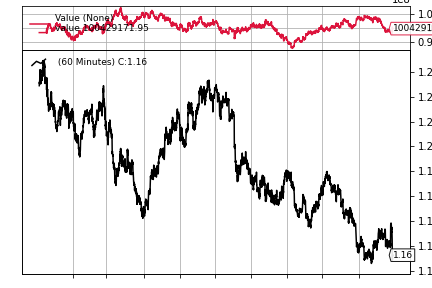

429171.95414461195

In [5]:
run_Trend(100000000, day)

# BTCUSD

[*********************100%***********************]  1 of 1 completed


<IPython.core.display.Javascript object>


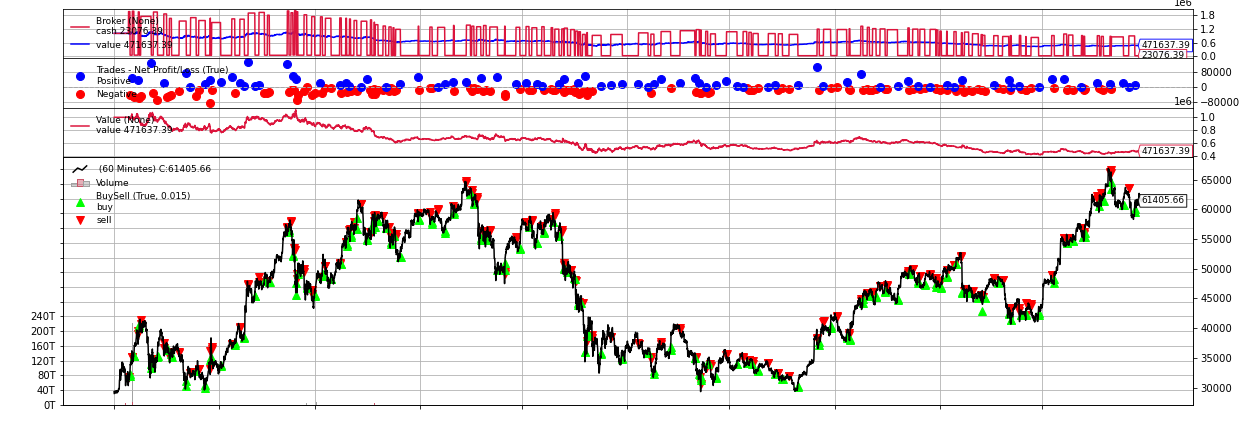

-528362.6065826155

In [14]:
day =  yf.download("BTC-USD",start="2021-1-1", end="2021-12-30",interval = "1h") 
day = bt.feeds.PandasData(dataname=day, timeframe=bt.TimeFrame.Minutes, compression=60)
run_Trend(1000000, day)

<IPython.core.display.Javascript object>


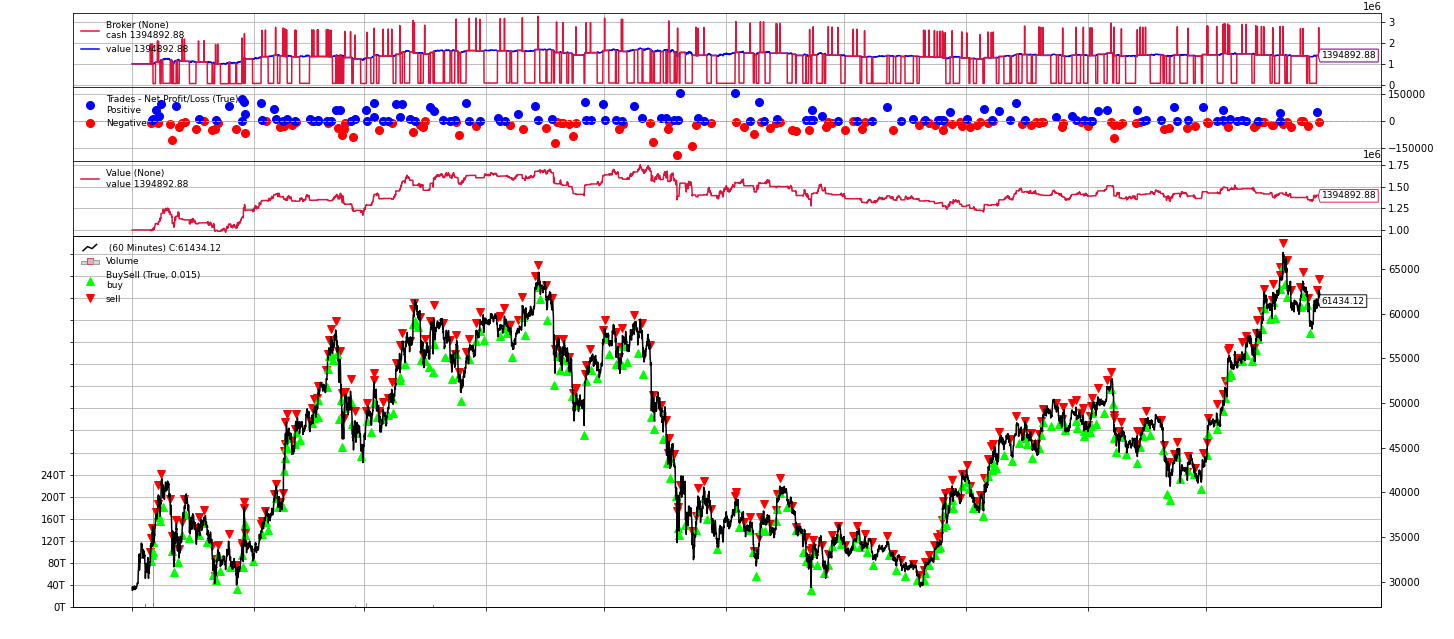

(('Final Value:', 1394892.8780059395),
 ('Sharpe Ratio:', OrderedDict([('sharperatio', None)])),
 ('Draw Down:',
  AutoOrderedDict([('len', 4155),
                   ('drawdown', 20.565026757773737),
                   ('moneydown', 361125.68796298373),
                   ('max',
                    AutoOrderedDict([('len', 4155),
                                     ('drawdown', 31.106831774428723),
                                     ('moneydown', 546241.7412436886)]))])))

In [13]:
run_Revert(1000000, day)